# Application to real-world cases
We here want to demonstrate the necessary steps to real-world cases. A new manuspcript introducing the necessary steps, the results, as well as an uncertainty estimation based on the evaluation with glacier observations is accepted for publication in Frontiers in Earth Science. 

## Set-up

In [2]:
import sys
import os
import salem

from initialization.core import *
from initialization.plots import *

from oggm import cfg, workflow,utils
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline
# settings for plots
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =15
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize']= 15 
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['figure.figsize'] = 10,10


cfg.initialize()

# path to working and plot directory
WORKING_DIR = 'workdir'
cfg.PATHS['working_dir'] = WORKING_DIR

utils.mkdir(cfg.PATHS['working_dir'], reset=False)
cfg.PATHS['plot_dir'] = os.path.join(cfg.PATHS['working_dir'], 'plots')
utils.mkdir(cfg.PATHS['plot_dir'], reset=False)

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = True

# How many grid points around the glacier?
cfg.PARAMS['border'] = 200

# Set to True for operational runs
cfg.PARAMS['continue_on_error'] = True

# We use intersects
db = utils.get_rgi_intersects_region_file(version='61', region='11')
cfg.set_intersects_db(db)

cfg.PARAMS['run_mb_calibration'] = True
cfg.PARAMS['optimize_inversion_params'] = False

# read shapefile with 66 glaciers in the Oetztal Alps
rgidf = salem.read_shapefile('../rgi/oetztal.shp')

# sort for efficient using
rgidf = rgidf.sort_values('Area', ascending=False)

# select Hintereisferner only
gdir = workflow.init_glacier_regions(rgidf[rgidf.RGIId=='RGI60-11.00897'])[0]

# preprocessing 
preprocessing(gdir)

2021-01-28 12:50:02: oggm.cfg: Using configuration file: /home/julia/oggm/oggm/params.cfg
2021-01-28 12:50:02: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2021-01-28 12:50:02: oggm.workflow: Multiprocessing: using all available processors (N=8)
2021-01-28 12:50:02: oggm.core.gis: (RGI60-11.00897) glacier_masks
2021-01-28 12:50:03: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2021-01-28 12:50:03: oggm.core.centerlines: (RGI60-11.00897) compute_centerlines
2021-01-28 12:50:03: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2021-01-28 12:50:03: oggm.core.centerlines: (RGI60-11.00897) initialize_flowlines
2021-01-28 12:50:03: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2021-01-28 12:50:03: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_line
2021-01-28 12:50:06: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2021-01-28 12:50:06: oggm.core.centerlines: (RGI

In [3]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-11.00897
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Name: Hintereisferner
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 8.036 km2
  Lon, Lat: (10.7584, 46.8003)
  Grid (nx, ny): (519, 474)
  Grid (dx, dy): (50.0, -50.0)

## The drawback of synthetic experiements
In the previous notebook we introduced the synthetic experiements, which do not necessarily represent real-world cases. In order to clarify this, we will create the synthetic experiment again:  


In [4]:
synthetic_experiments_parallel([gdir], 1917,gdir.rgi_date)

2021-01-28 10:51:08: oggm.core.flowline: (RGI60-11.00897) run_random_climate
2021-01-28 10:51:08: oggm.core.flowline: (RGI60-11.00897) trying default time stepping scheme.
2021-01-28 10:53:10: oggm.core.flowline: (RGI60-11.00897) default time stepping was successful!
2021-01-28 10:53:10: oggm.core.flowline: (RGI60-11.00897) run_from_climate_data_synthetic_experiment
2021-01-28 10:53:10: oggm.core.flowline: (RGI60-11.00897) trying default time stepping scheme.
2021-01-28 10:53:19: oggm.core.flowline: (RGI60-11.00897) default time stepping was successful!


RGI state:   6.9 km, 8.05 km², 0.76 km³
synth. exp.: 9.9 km, 9.88 km², 1.11 km³


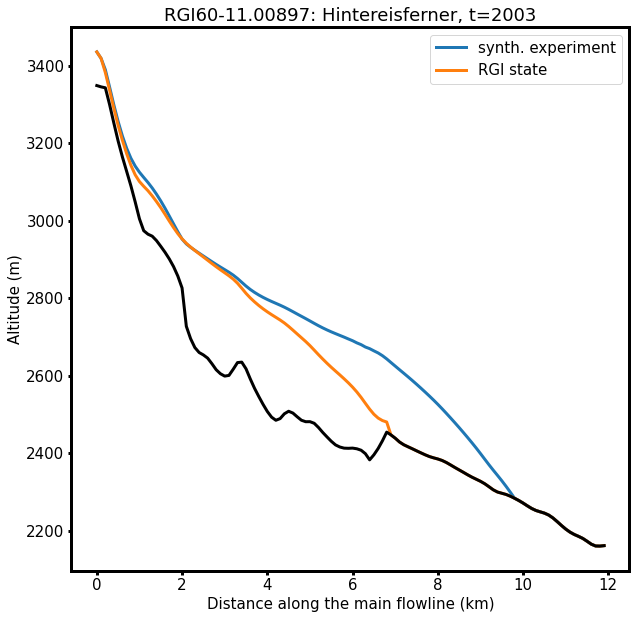

In [4]:
# reads the expermient model
ep = gdir.get_filepath('model_run', filesuffix='_synthetic_experiment')
ex_mod = FileModel(ep)

# read model_flowlines (RGI state)
fls = gdir.read_pickle('model_flowlines')
fls_mod = FluxBasedModel(flowlines=fls)
ex_mod.run_until(gdir.rgi_date)
x = (np.arange(ex_mod.fls[-1].nx) * ex_mod.fls[-1].dx * ex_mod.fls[-1].map_dx)[:120]/1000

# plot the surface elevations of the synthetic experiment and the RGI state
plt.plot(x,ex_mod.fls[-1].surface_h[:120], color='C0', label='synth. experiment')
plt.plot(x,fls_mod.fls[-1].surface_h[:120], color='C1', label='RGI state')
plt.plot(x,ex_mod.fls[-1].bed_h[:120], color='k')
plt.legend()
plt.title(gdir.rgi_id+': Hintereisferner, t='+str(gdir.rgi_date))
plt.xlabel('Distance along the main flowline (km)')
plt.ylabel('Altitude (m)');

print('RGI state:   '+ str(fls_mod.length_m/1000)+' km, '+str(round(fls_mod.area_km2,2)) +r' km², '+str(round(fls_mod.volume_km3,2)) +r' km³')
print('synth. exp.: '+ str(ex_mod.length_m/1000)+' km, '+str(round(ex_mod.area_km2,2)) +r' km², ' +str(round(ex_mod.volume_km3,2)) +r' km³')

The example above demonstrate well why the synthetic experiement did not always represent the reality. The synthetic experiment state differs strongly from the RGI state (the state obtained by the RGI outline and the underlying topography file). The synthetic experiement state is 3 km longer and thus also a reconstruction of this state would not represent realistic conditions. 

To this end, we developed the method further and introduce the so called calibration runs
## Real-world application: Calibration runs

With the help of the calibration runs we identify an optimal mass balance offset, such that the difference of the experiment to the area of the RGI state is as small as possible. To this end, a bisection method is used which stop thank to the quick convergence after 12 iterations latest. 

In [6]:
calibration_runs([gdir],1917)

2021-01-28 10:58:36: oggm.core.flowline: (RGI60-11.00897) run_random_climate_calibration_random_0.0
2021-01-28 10:58:36: oggm.core.flowline: (RGI60-11.00897) trying default time stepping scheme.
2021-01-28 10:59:36: oggm.core.flowline: (RGI60-11.00897) default time stepping was successful!
2021-01-28 10:59:36: oggm.core.flowline: (RGI60-11.00897) run_from_climate_data_calibration_past_0.0
2021-01-28 10:59:36: oggm.core.flowline: (RGI60-11.00897) trying default time stepping scheme.
2021-01-28 10:59:42: oggm.core.flowline: (RGI60-11.00897) default time stepping was successful!
2021-01-28 10:59:42: oggm.core.flowline: (RGI60-11.00897) run_random_climate_calibration_random_1000.0
2021-01-28 10:59:42: oggm.core.flowline: (RGI60-11.00897) trying default time stepping scheme.
2021-01-28 11:00:04: oggm.core.flowline: (RGI60-11.00897) default time stepping was successful!
2021-01-28 11:00:04: oggm.core.flowline: (RGI60-11.00897) run_from_climate_data_calibration_past_1000.0
2021-01-28 11:00:04

The function `calibration_runs` creates during each iteration a model_run outputfile with the filesuffix of the tested mass balance offset. Only the model with the smallest area difference to the RGI state is kept, all the others are deleted automatically in the end. 

In [5]:
# get calibration run output file (OGGM state)
ex = [f for f in os.listdir(gdir.dir) if f.startswith('model_run_calibration_past')][0]
dst = os.path.join(gdir.dir,ex)
cal_mod = FileModel(dst)
cal_mod.run_until(gdir.rgi_date)

# get the optimal mb offset value from file name 
optimal_mb_offset = float(dst.split('_')[-1].split('.nc')[0])
optimal_mb_offset

97.9

RGI state:       6.9 km, 8.05 km², 0.76 km³
calibration run: 7.4 km, 8.04 km², 0.79 km³
synth. exp.:     9.9 km, 9.88 km², 1.11 km³


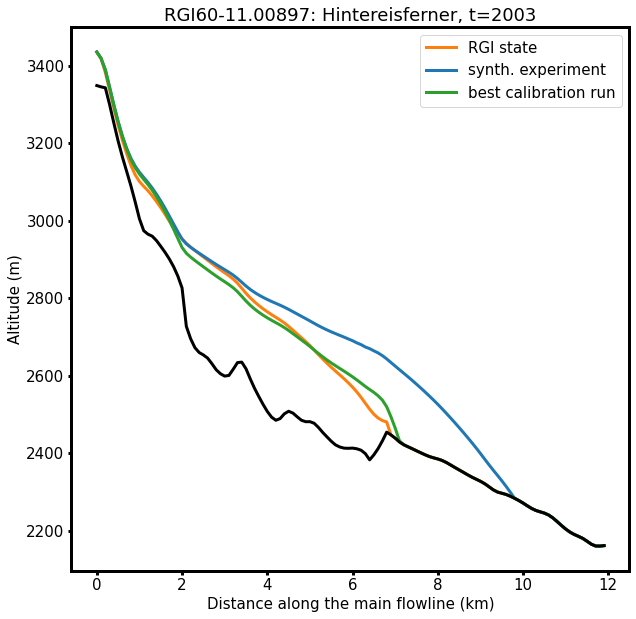

In [6]:
# reads the expermient model
ep = gdir.get_filepath('model_run', filesuffix='_synthetic_experiment')
ex_mod = FileModel(ep)
ex_mod.run_until(gdir.rgi_date)

# read model_flowlines (RGI state)
fls = gdir.read_pickle('model_flowlines')
fls_mod = FluxBasedModel(flowlines=fls)

x = (np.arange(fls_mod.fls[-1].nx) * fls_mod.fls[-1].dx * fls_mod.fls[-1].map_dx)[:120]/1000
plt.plot(x,fls_mod.fls[-1].surface_h[:120], color='C1', label='RGI state')
plt.plot(x,ex_mod.fls[-1].surface_h[:120], color='C0', label='synth. experiment')
plt.plot(x,cal_mod.fls[-1].surface_h[:120], color='C2', label='best calibration run')

plt.plot(x,cal_mod.fls[-1].bed_h[:120], color='k')
plt.legend()
plt.title(gdir.rgi_id+': Hintereisferner, t='+ str(gdir.rgi_date))
plt.xlabel('Distance along the main flowline (km)')
plt.ylabel('Altitude (m)');

print('RGI state:       '+ str(fls_mod.length_m/1000)+' km, '+str(round(fls_mod.area_km2,2)) +r' km², '+str(round(fls_mod.volume_km3,2)) +r' km³')
print('calibration run: '+ str(cal_mod.length_m/1000)+' km, '+str(round(cal_mod.area_km2,2)) +r' km², ' +str(round(cal_mod.volume_km3,2)) +r' km³')
print('synth. exp.:     '+ str(ex_mod.length_m/1000)+' km, '+str(round(ex_mod.area_km2,2)) +r' km², ' +str(round(ex_mod.volume_km3,2)) +r' km³')

## Real World Application: The actual initialization
Now, we are ready to start the actual initialization procedure. To this end you need to run the following function (This can take a long time!!!). Important for the real world application is that you hand over the optimal mass balance offset value `optimal_mb_offset` from above and the File Model from the calibration run `cal_mod`. Otherwise the function will use the default value (mb offset=0 and the synthetic experiment). We reduced the number of glacier candidates in this example to `n=20` (default value is `n=200`) in order to save computational costs. 

In [12]:
results = find_possible_glaciers(gdir, 1917, gdir.rgi_date, 20, ex_mod=cal_mod, mb_offset=optimal_mb_offset)

In order to plot the results (here with 20 glacier candidates only) use: 

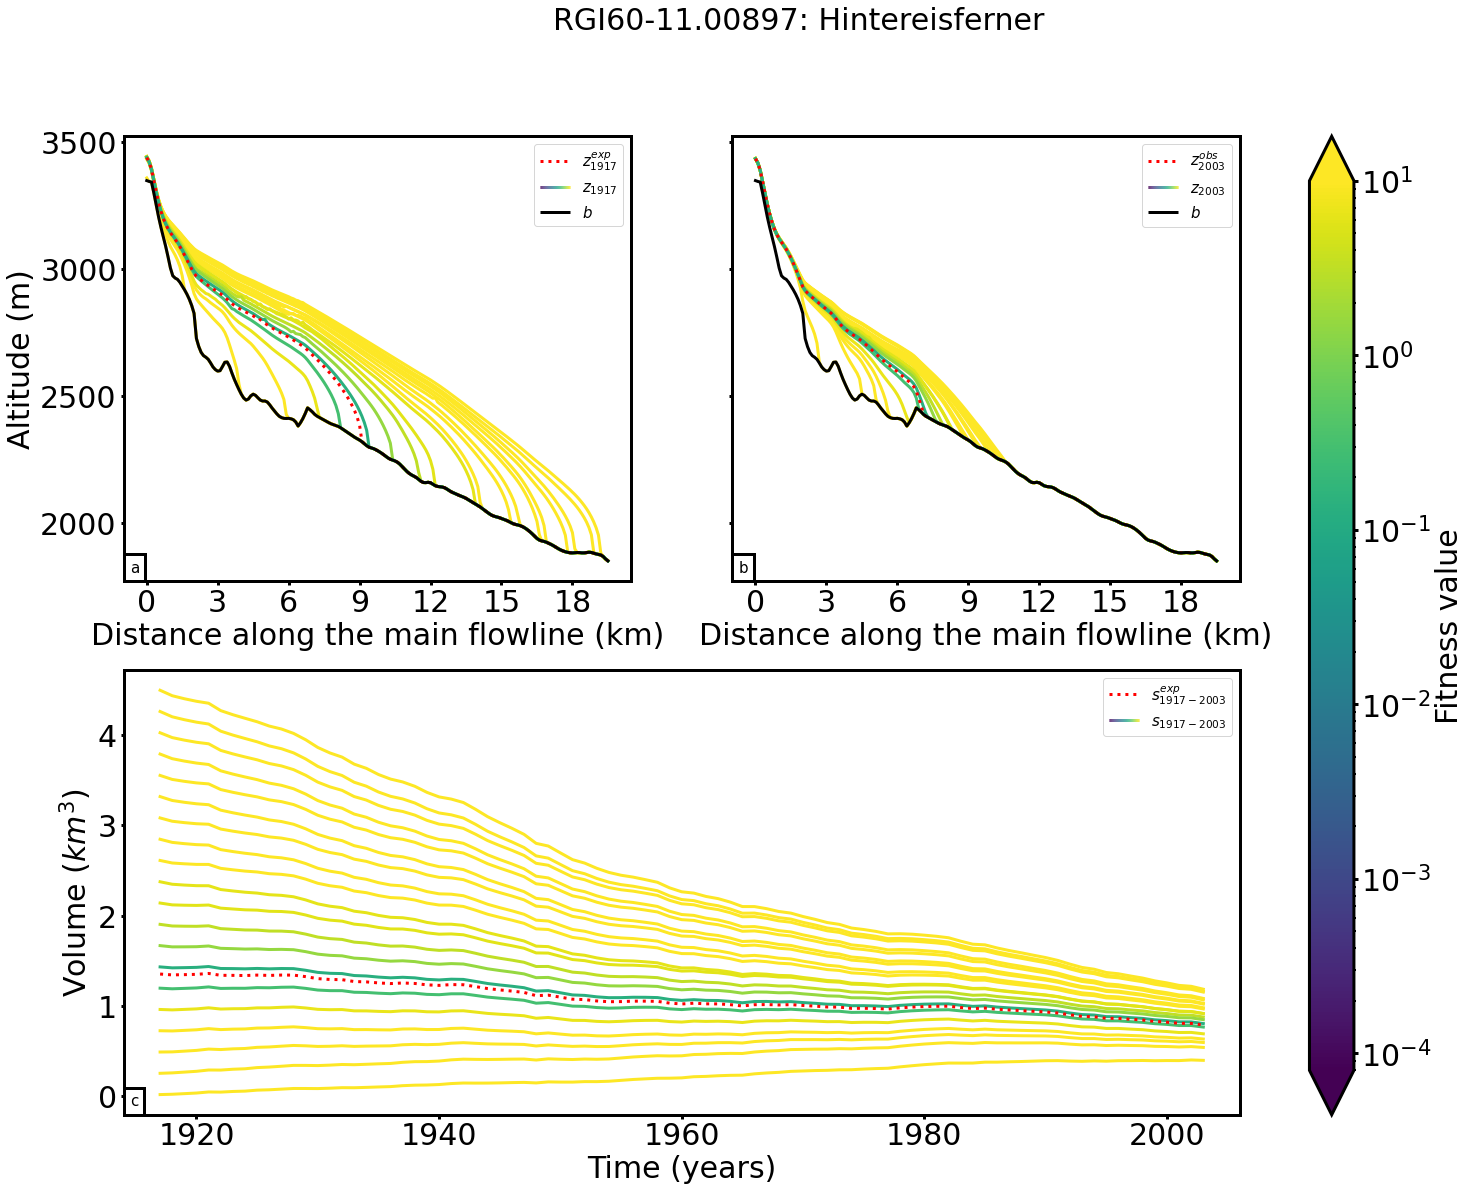

In [11]:
plot_fitness_values(gdir, results,cal_mod, 1917,gdir.rgi_date, cfg.PATHS['plot_dir'])

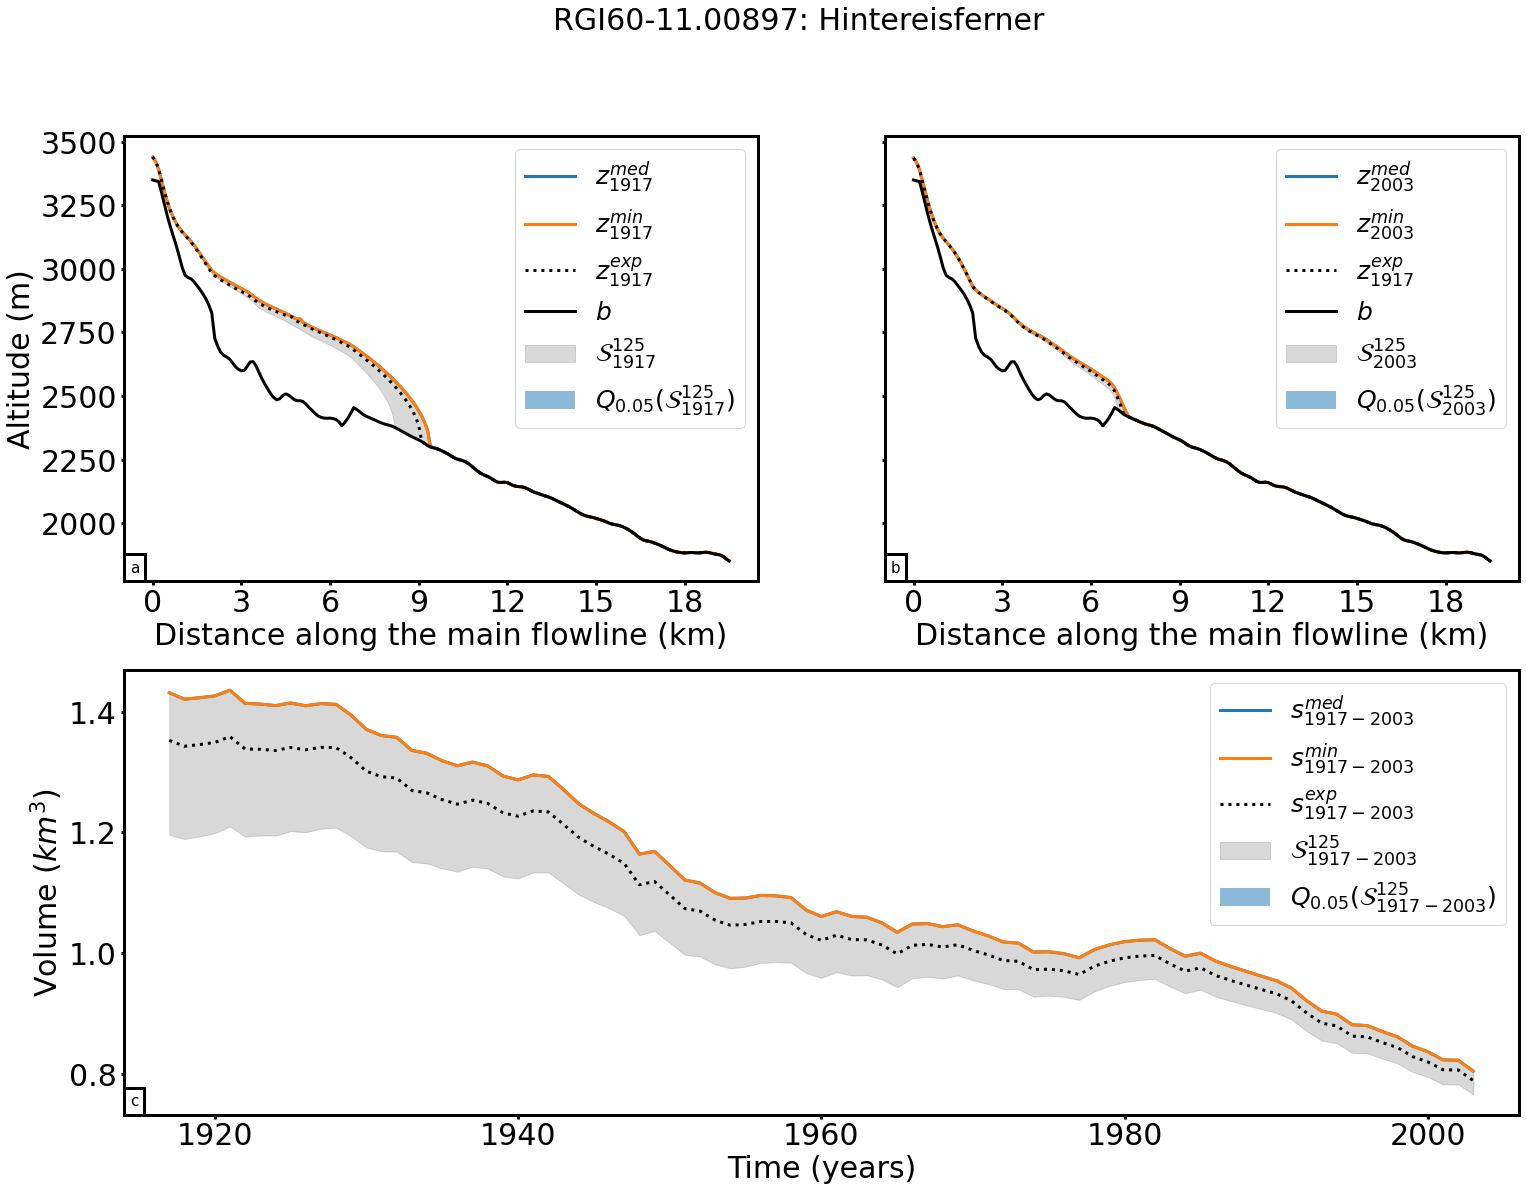

In [14]:
plot_median(gdir, results,125, cal_mod, 1917,gdir.rgi_date, cfg.PATHS['plot_dir'])